In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

### List of specific speech URLs

In [4]:
speech_urls = [
    'https://www.presidency.ucsb.edu/documents/inaugural-address-53',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-14',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-15',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-28',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-17',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union'
]

### Here I created a function to get the title, date, and contenth for each presidential speech provided.

In [5]:
def scrape_speech(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract title
    title = soup.find('h1').text if soup.find('h1') else 'No Title'
    
    date_div = soup.find('div', {'class': 'field-docs-start-date-time'})
    date = date_div.find('span').get('content') if date_div else 'No Date'
    
    # Extract content
    content_div = soup.find('div', {'class': 'field-docs-content'})
    content = content_div.text.strip() if content_div else 'No Content'
    
    return title, date, content

### For every url provided, I will call the scrape fucntion and store the title, data, and content in an array to then turn it into a data frame.

In [6]:
speeches = []
for url in speech_urls:
    try:
        title, date, content = scrape_speech(url)
        speeches.append({'title': title, 'date': date, 'content': content})
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")

df = pd.DataFrame(speeches)
df.to_csv('presidential_speeches.csv', index=False)

print("Data collection complete. Saved to presidential_speeches.csv")

Data collection complete. Saved to presidential_speeches.csv


### This part of the code initializes two key components for text preprocessing:
- `stop_words`: A set of common English words (like "and", "the", "is") that are often removed from text data because they do not contribute much to the meaning.
- `lemmatizer`: An instance of the `WordNetLemmatizer` class, which is used to reduce words to their base or root form (e.g., "running" becomes "run"). This helps in standardizing the words in the text data.

In [7]:
df = pd.read_csv('presidential_speeches.csv')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text.lower())
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)


### This part of the code processes the text of each speech and saves the cleaned data to a new CSV file:
- The `preprocess_text` function is applied to each speech in the 'content' column, and the results are stored in a new column called 'processed_content'.
- The DataFrame, now including the cleaned text, is saved to a CSV file named 'processed_presidential_speeches.csv'.
- A message is printed to confirm that the preprocessing is complete and the data is saved.

In [9]:
# Apply preprocessing to the content column
df['processed_content'] = df['content'].apply(preprocess_text)

df.to_csv('processed_presidential_speeches.csv', index=False)

print("Text preprocessing complete. Saved to processed_presidential_speeches.csv")

Text preprocessing complete. Saved to processed_presidential_speeches.csv


### This section sets up the VADER sentiment intensity analyzer, which will be used to analyze the sentiment of the preprocessed text. The function `get_sentiment` is defined to calculate the sentiment scores for a given text.

In [10]:
df = pd.read_csv('processed_presidential_speeches.csv')

sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    return sia.polarity_scores(text)

### This code chunk applies the sentiment analysis function to the processed content of each speech. The sentiment scores (positive, negative, neutral, and compound) are calculated and stored in a new DataFrame.

In [11]:
# Apply sentiment analysis to the processed content
df['sentiment'] = df['processed_content'].apply(get_sentiment)

# Expand sentiment dictionary into separate columns
sentiment_df = df['sentiment'].apply(pd.Series)

# Concatenate the sentiment columns to the original dataframe
df = pd.concat([df, sentiment_df], axis=1)

# Save the dataframe with sentiment scores
df.to_csv('presidential_speeches_with_sentiment.csv', index=False)

print("Sentiment analysis complete. Saved to presidential_speeches_with_sentiment.csv")

Sentiment analysis complete. Saved to presidential_speeches_with_sentiment.csv


In [12]:
for index, row in df.iterrows():
    sentiment_scores = sia.polarity_scores(row['processed_content'])
    df.at[index, 'sentiment'] = sentiment_scores
    print(f"Title: {row['title']}")
    print(f"Date: {row['date']}")
    print(f"Sentiment Scores: {sentiment_scores}")
    print("-" * 80)

Title: Inaugural Address
Date: 2021-01-20T11:52:00+00:00
Sentiment Scores: {'neg': 0.159, 'neu': 0.563, 'pos': 0.278, 'compound': 0.9994}
--------------------------------------------------------------------------------
Title: Inaugural Address
Date: 2017-01-20T12:04:00+00:00
Sentiment Scores: {'neg': 0.095, 'neu': 0.578, 'pos': 0.326, 'compound': 0.9997}
--------------------------------------------------------------------------------
Title: Inaugural Address
Date: 2013-01-21T11:55:00+00:00
Sentiment Scores: {'neg': 0.138, 'neu': 0.581, 'pos': 0.282, 'compound': 0.9995}
--------------------------------------------------------------------------------
Title: Address Before a Joint Session of the Congress on the State of the Union
Date: 2022-03-01T21:08:00+00:00
Sentiment Scores: {'neg': 0.131, 'neu': 0.643, 'pos': 0.226, 'compound': 0.9999}
--------------------------------------------------------------------------------
Title: Address Before a Joint Session of the Congress on the State of

### Visualizations

In [13]:
df = pd.read_csv('presidential_speeches_with_sentiment.csv')

df['url'] = speech_urls

# Map the URLs to president names
url_to_president = {
    'https://www.presidency.ucsb.edu/documents/inaugural-address-53': 'Joe Biden',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-14': 'Donald Trump',
    'https://www.presidency.ucsb.edu/documents/inaugural-address-15': 'Barack Obama',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-28': 'Joe Biden',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-17': 'Barack Obama',
    'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union': 'George W. Bush'
}

df['president'] = df['url'].map(url_to_president)


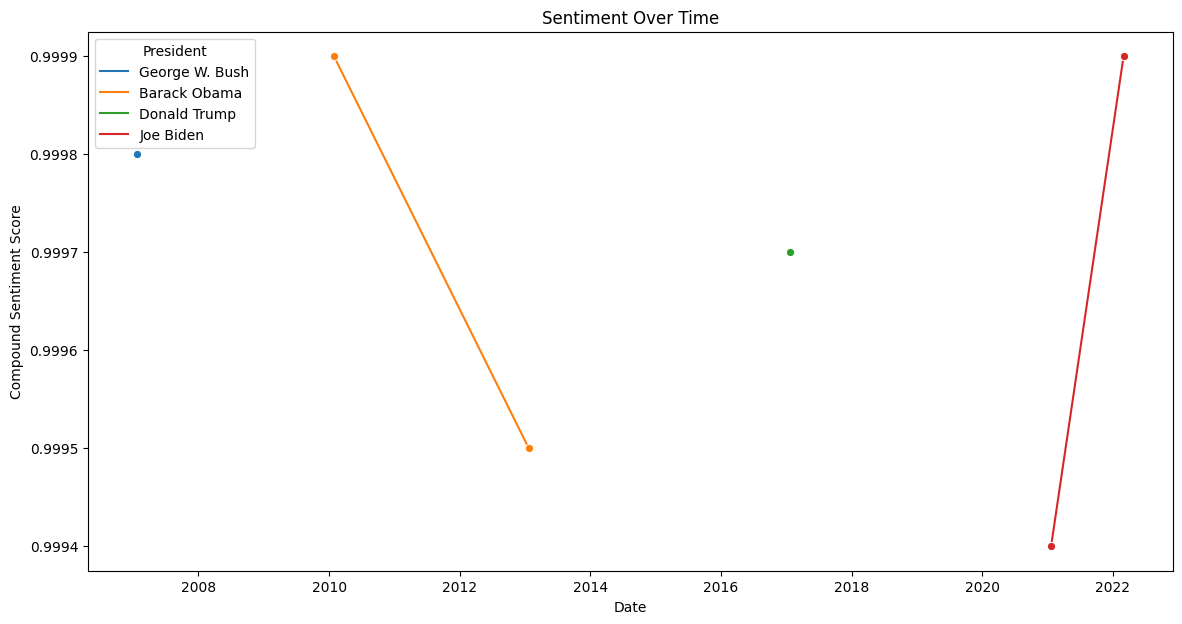

In [14]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce')

# Sort dataframe by date
df = df.sort_values(by='date')

plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='date', y='compound', hue='president', marker='o')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend(title='President')
plt.show()

#### Interpretation:
This line plot visualizes the compound sentiment scores of presidential speeches over time for Barack Obama and Joe Biden. Each line represents the sentiment trajectory during their respective terms.

- **Barack Obama**: The sentiment data for Obama shows a balanced sentiment throughout his presidency. His speeches often balanced optimism with realism, reflecting his focus on recovery from the financial crisis and pushing forward with healthcare reform. The steady sentiment scores indicate his consistent rhetorical approach to address both achievements and ongoing challenges.

- **Joe Biden**: The data for Biden, although limited to the early years of his term, shows a high positive sentiment, likely reflecting his efforts to unite the country and address ongoing issues like the COVID-19 pandemic and economic recovery. His speeches emphasize steady and reassuring communication, aimed at maintaining public confidence during these times.

These insights highlight the different rhetorical strategies employed by Obama and Biden in response to their unique political landscapes, providing a clearer understanding of their communication styles and priorities during their presidencies.

In [15]:
import plotly.graph_objects as go
import plotly.express as px

# Calculate average sentiment scores by president
average_sentiments = df.groupby('president')[['pos', 'neg', 'neu', 'compound']].mean().reset_index()

melted_avg_sentiments = average_sentiments.melt(id_vars='president', var_name='Sentiment', value_name='Score')

fig = px.bar(
    melted_avg_sentiments,
    x='president',
    y='Score',
    color='Sentiment',
    barmode='group',
    title='Average Sentiment Scores by President',
    labels={'Score': 'Average Score', 'president': 'President'}
)

fig.show()

#### Interpretation:
This bar chart compares the average sentiment scores (positive, negative, and compound) for each president. By analyzing these scores, we can infer the overall emotional tone of each president's speeches.

- **Barack Obama**: Exhibits a balanced emotional tone with moderate positive and negative sentiment scores. This suggests a measured approach in addressing both challenges and achievements.
- **Donald Trump**: Shows the highest average positive sentiment among the presidents analyzed, indicating a more optimistic and perhaps assertive rhetorical style.
- **George W. Bush**: Has the highest average negative sentiment score, reflecting the turbulent times of his presidency, such as post-9/11 events and the Iraq War.
- **Joe Biden**: Displays the highest average neutral sentiment, suggesting a focus on informative and steady communication, possibly to maintain public confidence during ongoing crises like the COVID-19 pandemic.

These interpretations highlight how each president's rhetoric aligns with their political context and the challenges they faced, providing insights into their communication strategies and the overall emotional tone of their public addresses.

### Network Analysis

In this section, I will add a network analysis component to the project. This will help identify the relationships between different themes or keywords in the presidential speeches. By constructing and analyzing a network graph, I aim to uncover influential themes and their interconnections.

### Extract Keywords using NLTK

I start by extracting the most common keywords from the processed speech texts.

In [19]:
from nltk.probability import FreqDist

all_words = ' '.join(df['processed_content']).split()
fdist = FreqDist(all_words)
keywords = [word for word, freq in fdist.most_common(100)]  

### Create a Co-occurrence Matrix

Next, I create a co-occurrence matrix where each cell represents the frequency of two keywords appearing together in the same speech. This matrix will be used to build the network graph.

In [20]:
import numpy as np
from collections import defaultdict

co_occurrence_matrix = defaultdict(lambda: defaultdict(int))

# Update co-occurrence counts
for text in df['processed_content']:
    words = set(text.split())
    for word1 in words:
        for word2 in words:
            if word1 != word2:
                co_occurrence_matrix[word1][word2] += 1

# Convert to a numpy array for easier manipulation
keywords_list = list(keywords)
co_matrix = np.zeros((len(keywords_list), len(keywords_list)))

for i, word1 in enumerate(keywords_list):
    for j, word2 in enumerate(keywords_list):
        co_matrix[i, j] = co_occurrence_matrix[word1][word2]

### Build a Graph Using NetworkX

I then build a network graph using the NetworkX library, where nodes represent keywords, and edges represent the co-occurrence frequency between keywords.

In [21]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from(keywords_list)

for i, word1 in enumerate(keywords_list):
    for j, word2 in enumerate(keywords_list):
        if i != j and co_matrix[i, j] > 0:
            G.add_edge(word1, word2, weight=co_matrix[i, j])

### Analyze the Network

Now, I perform various network analyses to find important keywords (nodes) and relationships (edges) in the speeches. This includes calculating centrality measures to identify influential themes.

In [22]:
degree_centrality = nx.degree_centrality(G)
print("Degree Centrality:", degree_centrality)

betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness Centrality:", betweenness_centrality)

closeness_centrality = nx.closeness_centrality(G)
print("Closeness Centrality:", closeness_centrality)

Degree Centrality: {'american': 1.0, 'america': 1.0, 'year': 1.0, 'people': 1.0, 'u': 1.0, 'nation': 1.0, 'one': 1.0, 'new': 1.0, 'let': 1.0, 'country': 1.0, 'job': 1.0, 'make': 1.0, 'time': 1.0, 'know': 1.0, 'world': 1.0, 'must': 1.0, 'need': 1.0, 'work': 1.0, 'get': 1.0, 'would': 1.0, 'family': 1.0, 'state': 1.0, 'every': 1.0, 'right': 1.0, 'child': 1.0, 'tonight': 1.0, 'tax': 1.0, 'life': 1.0, 'like': 1.0, 'many': 1.0, 'business': 1.0, 'president': 1.0, 'take': 1.0, 'health': 1.0, 'united': 1.0, 'day': 1.0, 'together': 1.0, 'government': 1.0, 'much': 1.0, 'help': 1.0, 'million': 1.0, 'look': 1.0, 'economy': 1.0, 'way': 1.0, 'great': 1.0, 'come': 1.0, 'last': 1.0, 'war': 1.0, 'care': 1.0, 'citizen': 1.0, 'cost': 1.0, 'thank': 1.0, 'congress': 1.0, 'even': 1.0, 'never': 1.0, 'law': 1.0, 'act': 1.0, 'also': 1.0, 'thing': 1.0, 'going': 1.0, 'iraq': 1.0, 'go': 1.0, 'first': 1.0, 'security': 1.0, 'plan': 1.0, 'see': 1.0, 'home': 1.0, 'keep': 1.0, 'give': 1.0, 'fight': 1.0, 'back': 1.0, 'g

### Visualize the Network

Finally, I visualize the network to understand the relationships between keywords. This visualization helps to identify clusters of related themes and the overall structure of the network.

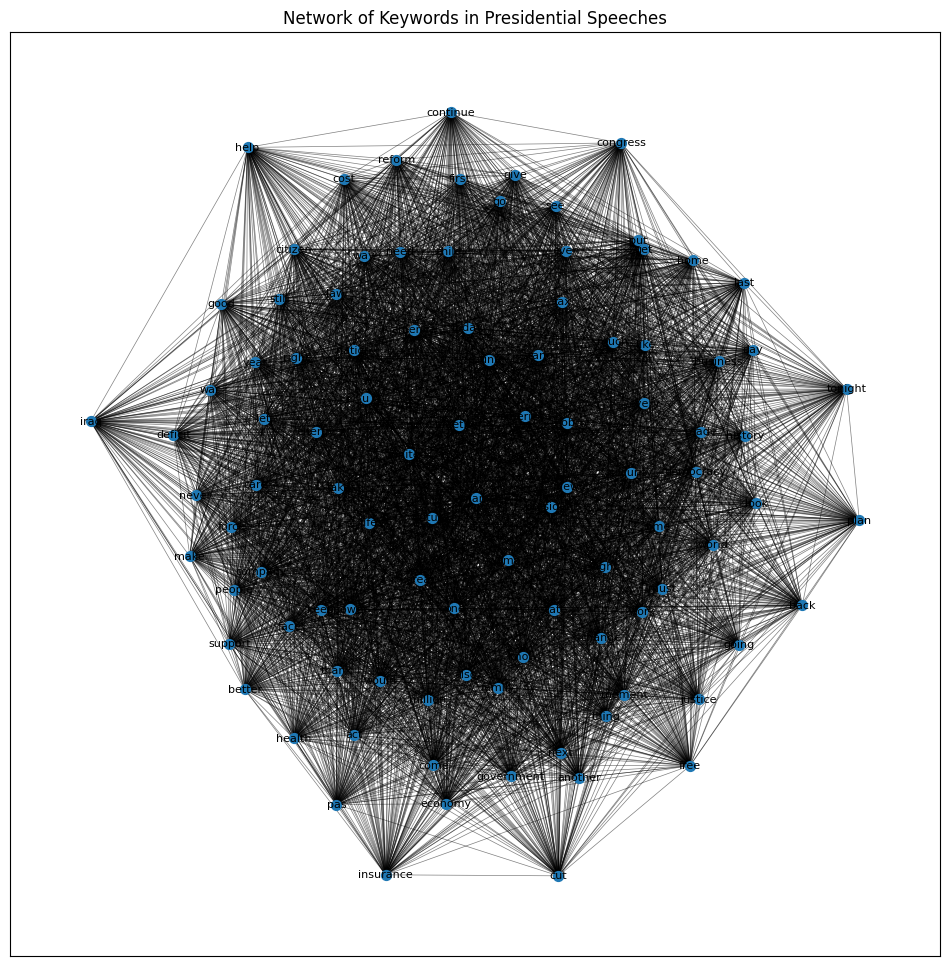

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Network of Keywords in Presidential Speeches')
plt.show()

### Simplifying the Network with a Degree Threshold

To simplify the very clustered network, I apply a degree threshold. This means I only include nodes (keywords) that have a degree (number of connections) above a certain threshold. This helps focus on the most central and significant keywords, making the network easier to interpret.

#### Applying the Degree Threshold

98


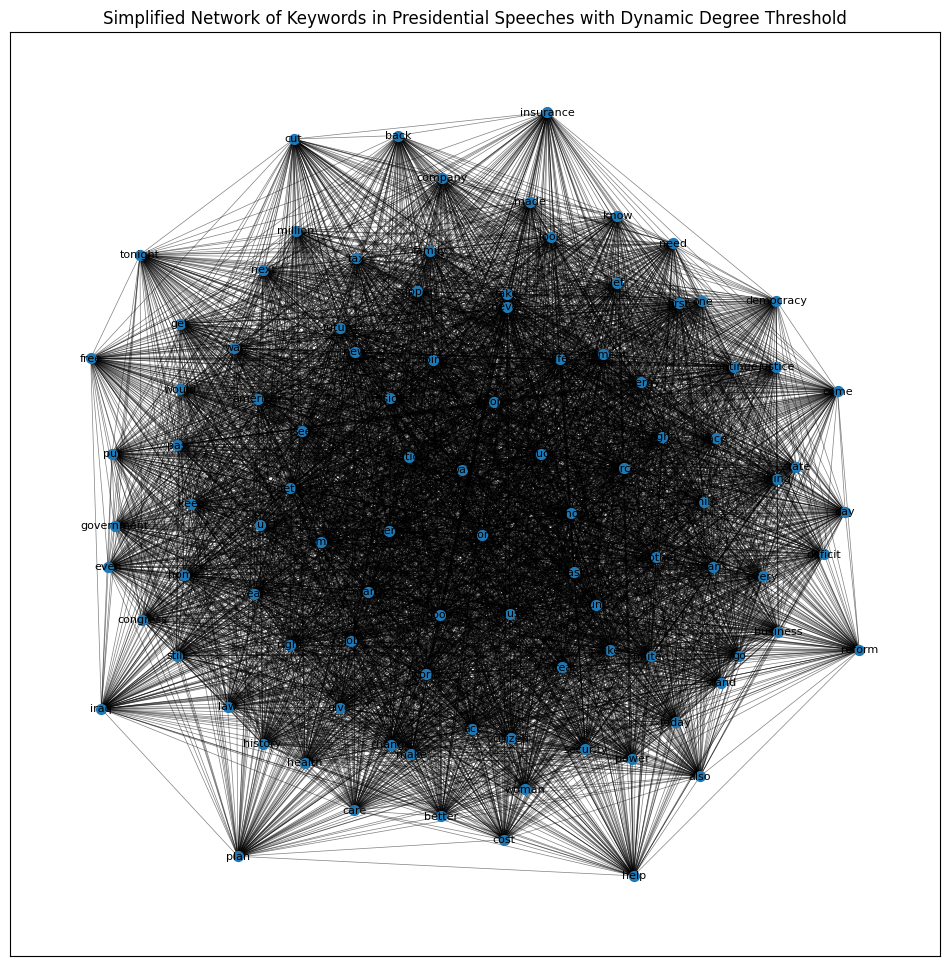

In [52]:
degrees = [degree for node, degree in G.degree()]
mean_degree = np.mean(degrees)

degree_threshold = 98
print(degree_threshold)

filtered_nodes_dynamic = [node for node, degree in G.degree() if degree > degree_threshold]
filtered_G_dynamic = G.subgraph(filtered_nodes_dynamic)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(filtered_G_dynamic, k=0.15)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw_networkx_nodes(filtered_G_dynamic, pos, node_size=50)
nx.draw_networkx_edges(filtered_G_dynamic, pos, width=0.5, alpha=0.5)
nx.draw_networkx_labels(filtered_G_dynamic, pos, font_size=8)
plt.title('Simplified Network of Keywords in Presidential Speeches with Dynamic Degree Threshold')
plt.show()

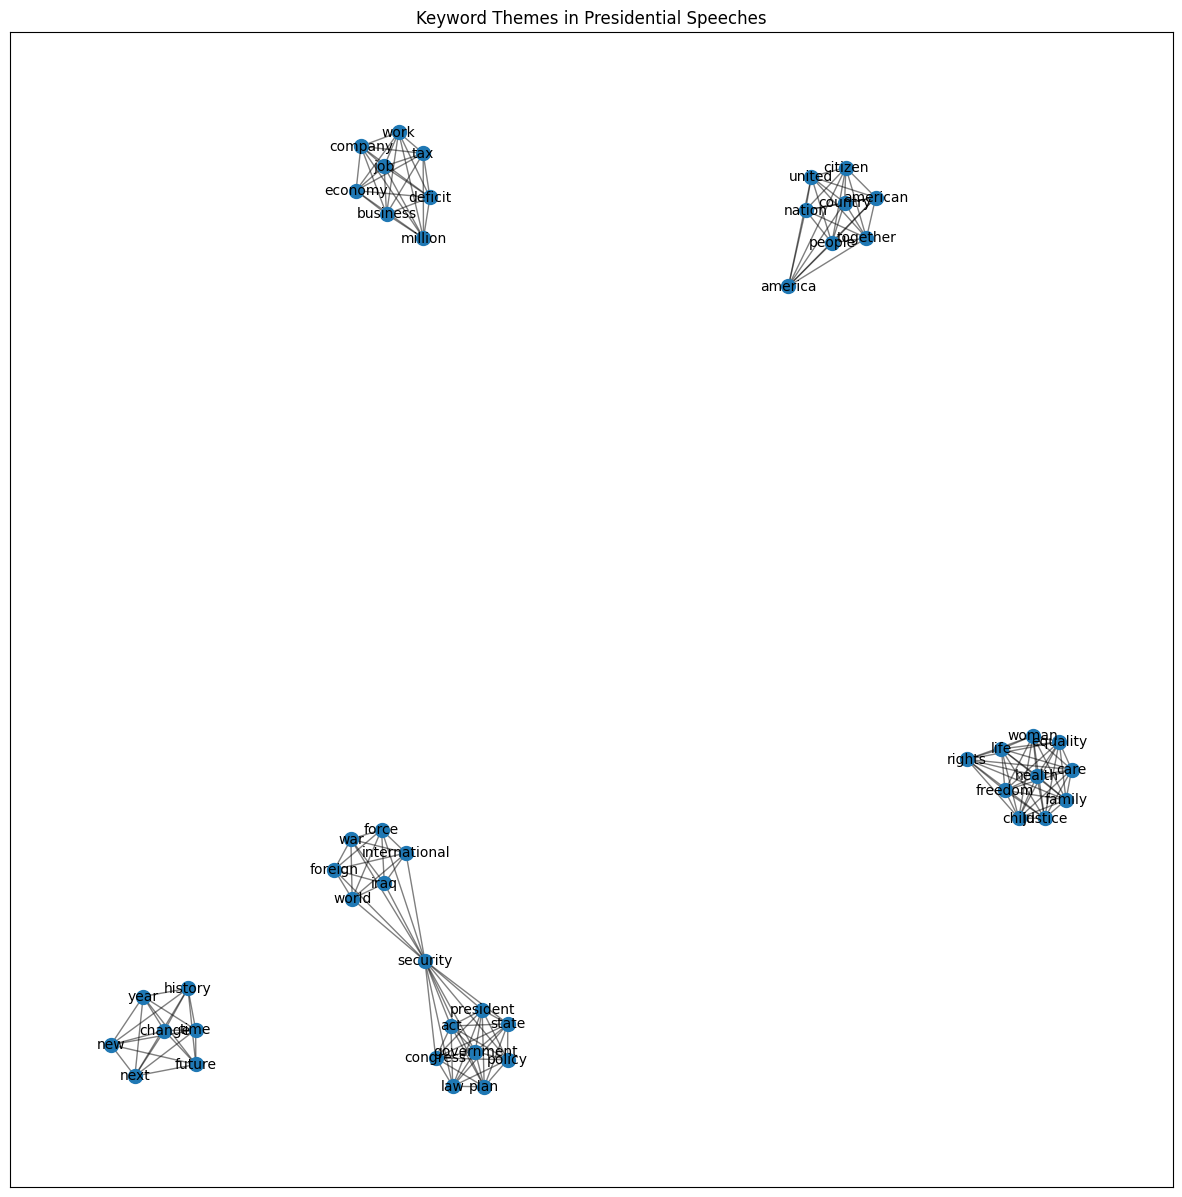

In [50]:
G_theme = nx.Graph()
themes = {
    "National Identity and Unity": ['american', 'america', 'nation', 'country', 'people', 'citizen', 'united', 'together'],
    "Governance and Legislation": ['government', 'congress', 'law', 'act', 'policy', 'plan', 'security', 'president', 'state'],
    "Economy and Jobs": ['economy', 'job', 'business', 'tax', 'deficit', 'work', 'million', 'company'],
    "Social Issues and Civil Rights": ['freedom', 'rights', 'justice', 'equality', 'health', 'care', 'family', 'child', 'woman', 'life'],
    "Global Affairs and War": ['world', 'war', 'iraq', 'force', 'security', 'foreign', 'international'],
    "Time and Progress": ['year', 'time', 'future', 'change', 'history', 'new', 'next']
}

for theme, keywords in themes.items():
    for keyword in keywords:
        G_theme.add_node(keyword, theme=theme)
    for i in range(len(keywords)):
        for j in range(i+1, len(keywords)):
            G_theme.add_edge(keywords[i], keywords[j])

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_theme, k=0.3)
nx.draw_networkx_nodes(G_theme, pos, node_size=100, cmap=plt.get_cmap('viridis'))
nx.draw_networkx_edges(G_theme, pos, alpha=0.5)
nx.draw_networkx_labels(G_theme, pos, font_size=10)

plt.title('Keyword Themes in Presidential Speeches')
plt.show()